In [97]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report, 
                             accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Prepare Data

## Import data

In [3]:
df = pd.read_csv("data/df_clean.csv")

## Explore data

In [4]:
print("Dimensions of the dataframe")
print(df.shape)

print("Information of dataset")
print(df.info())

Dimensions of the dataframe
(8586, 19)
Information of dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age_days                            8586 non-null   int64  
 1   sex                                 8586 non-null   object 
 2   region                              8586 non-null   object 
 3   area                                8586 non-null   object 
 4   child_lenhei_cm                     8586 non-null   float64
 5   child_weight_kg                     8586 non-null   float64
 6   child_ill_cough_two_weeks           8586 non-null   object 
 7   child_ill_fever_two_weeks           8586 non-null   object 
 8   child_had_diarrhoea_last_two_weeks  8586 non-null   object 
 9   health_insurance                    8586 non-null   object 
 10  mother_educational_level            8586 non-n

In [5]:
print("The first five rows")
print(df.head())

The first five rows
   age_days     sex   region   area  child_lenhei_cm  child_weight_kg  \
0       622    Male  Western  Rural             77.8              9.5   
1       431  Female  Western  Rural             70.6              7.0   
2      1295  Female  Western  Rural             95.3             11.9   
3       532  Female  Western  Rural             78.6              9.8   
4      1607    Male  Western  Rural            100.1             14.9   

  child_ill_cough_two_weeks child_ill_fever_two_weeks  \
0                        No                        No   
1                       Yes                        No   
2                        No                       Yes   
3                        No                       Yes   
4                       Yes                        No   

  child_had_diarrhoea_last_two_weeks   health_insurance  \
0                                 No     With insurance   
1                                Yes  Without insurance   
2                    

stunting
Normal      0.82716
Stunting    0.17284
Name: proportion, dtype: float64


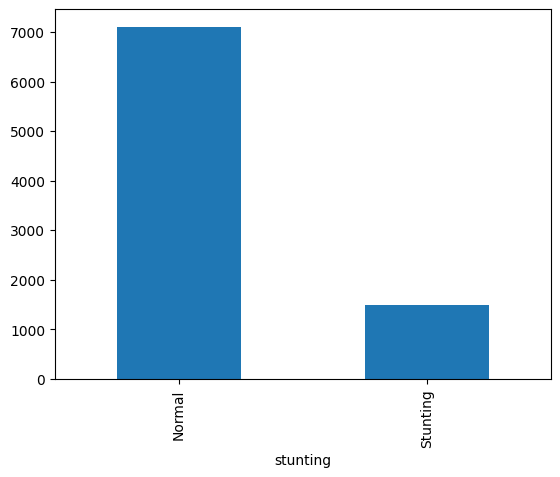

In [6]:
## Stunting
print(df["stunting"].value_counts(normalize=True))
df["stunting"].value_counts().plot(kind="bar");

wasting
Normal     0.930002
Wasting    0.069998
Name: proportion, dtype: float64


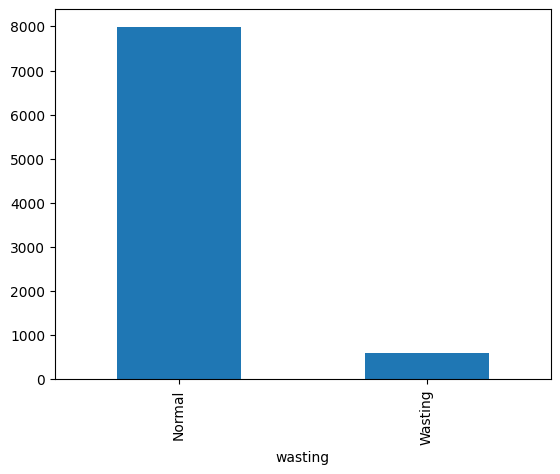

In [7]:
## Wasting
print(df["wasting"].value_counts(normalize=True))
df["wasting"].value_counts().plot(kind="bar");

underweight
Normal         0.877824
Underweight    0.122176
Name: proportion, dtype: float64


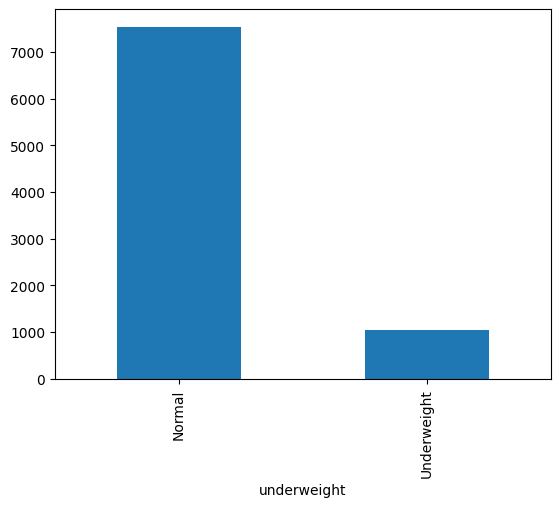

In [8]:
## Underweight
print(df["underweight"].value_counts(normalize=True))
df["underweight"].value_counts().plot(kind="bar");

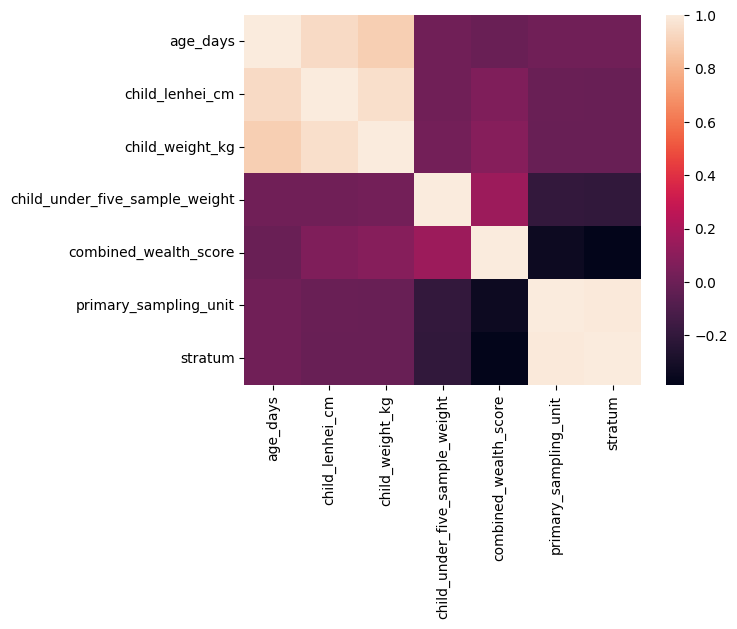

In [9]:
## Explore correlation of numeric variables
corr = df.select_dtypes("number").corr() # Find correlation of numeric variables
sns.heatmap(corr); # Plot heatmap


## Split data

In [72]:
# s: stunting; u: underweight; w: wasting
# Encode categorical features
le = LabelEncoder()

# Create feature matrix and target vectors
target_s = "stunting"
target_u = "underweight"
target_w = "wasting"

# Create target vector for each nutritional indicator
y_s = df[target_s]
y_s_encoded = le.fit_transform(y_s) # Encode target variable for stunting
y_s_encoded = pd.Series(y_s_encoded) # Convert np.array to pd.Series

## Underweight 
y_u = df[target_u]
y_u_encoded = le.fit_transform(y_u) # Encode target variable for underweight
y_u_encoded = pd.Series(y_u_encoded)  # Convert np.array to pd.Series

## Wasting
y_w = df[target_w]
y_w_encoded = le.fit_transform(y_w) # Encode target variable for wasting
y_w_encoded = pd.Series(y_w_encoded)  # Convert np.array to pd.Series

# Features
X = df.drop(columns=[target_s, target_u, target_w, "primary_sampling_unit", "stratum", "child_under_five_sample_weight"])
X.head()

,age_days,sex,region,area,child_lenhei_cm,child_weight_kg,child_ill_cough_two_weeks,child_ill_fever_two_weeks,child_had_diarrhoea_last_two_weeks,health_insurance,mother_educational_level,ethnicity,combined_wealth_score
0,622,Male,Western,Rural,77.8,9.5,No,No,No,With insurance,Jss/jhs/middle,Akan,0.153212
1,431,Female,Western,Rural,70.6,7.0,Yes,No,Yes,Without insurance,Primary,Akan,-0.068991
2,1295,Female,Western,Rural,95.3,11.9,No,Yes,No,Without insurance,Jss/jhs/middle,Akan,-0.263641
3,532,Female,Western,Rural,78.6,9.8,No,Yes,No,Without insurance,Jss/jhs/middle,Akan,-0.263641
4,1607,Male,Western,Rural,100.1,14.9,Yes,No,No,With insurance,Primary,Akan,0.087765


In [74]:
# View head of target vectors
print(y_s.head()) # Stunting
print(y_u.head()) # Underweight
print(y_w.head()) # Wasting

0    Stunting
1    Stunting
2      Normal
3      Normal
4      Normal
Name: stunting, dtype: object
0         Normal
1    Underweight
2         Normal
3         Normal
4         Normal
Name: underweight, dtype: object
0    Normal
1    Normal
2    Normal
3    Normal
4    Normal
Name: wasting, dtype: object


In [75]:
# Split data into training and test data

## Stunting
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s_encoded, test_size=0.3, random_state=42)

## Underweight
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X, y_u_encoded, test_size=0.3, random_state=42)

## Wasting
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y_w_encoded, test_size=0.3, random_state=42)

## Print dimensions of stunting split
print(X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape)

# Print dimensions of underweight split
print(X_train_u.shape, X_test_u.shape, y_train_u.shape, y_test_u.shape)

# Print dimensions of wasting split
print(X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape)

(6010, 13) (2576, 13) (6010,) (2576,)
(6010, 13) (2576, 13) (6010,) (2576,)
(6010, 13) (2576, 13) (6010,) (2576,)


# Build model

## Baseline model

In [76]:
# Stunting
baseline_s = y_train_s.value_counts(normalize=True).max()
print(f"Baseline accuracy for stunting is: {baseline_s}")

# Underweight
baseline_u = y_train_u.value_counts(normalize=True).max()
print(f"Baseline accuracy for underweight is: {baseline_u}")

# Wasting
baseline_w = y_train_w.value_counts(normalize=True).max()
print(f"Baseline accuracy for wasting is: {baseline_w}")

Baseline accuracy for stunting is: 0.8299500831946756
Baseline accuracy for underweight is: 0.8810316139767055
Baseline accuracy for wasting is: 0.9287853577371048


## Iterate

In [190]:
# Initialise models


# Numeric features
numeric_features = ["age_days",  
                    "child_lenhei_cm",
                    "child_weight_kg",  
                    "combined_wealth_score"]

# Categorical features
categorical_features = [
    "sex",
    "region",
    "area",
    "child_ill_cough_two_weeks",
    "child_ill_fever_two_weeks",
    "child_had_diarrhoea_last_two_weeks",
    "health_insurance",
    "mother_educational_level",
    "ethnicity"
]

# Create transformers for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

## Logistic regression
lr = make_pipeline(
    preprocessor,
    LogisticRegression(random_state=42, max_iter=1000)
)

## Lasso
lasso = make_pipeline(
    preprocessor,
    LogisticRegression(random_state=42, max_iter=1000, penalty="l1", solver="liblinear", C=10)
)

## Linear Discriminant Analysis
lda = make_pipeline(
                    OneHotEncoder(use_cat_names=True),
                    LinearDiscriminantAnalysis(shrinkage=None, solver="svd")
)

## Ridge Classifier
rr = make_pipeline(
    preprocessor,
                   RidgeClassifier(random_state=42, alpha=1, solver="auto")
)



## Support Vector Machines
svm = make_pipeline(
    preprocessor,
                    SVC(random_state=42, C=100, gamma="auto",kernel="rbf", probability=True)
)

## Random Forest
rf = make_pipeline(
    OneHotEncoder(),
    RandomForestClassifier(random_state=42, max_depth=40, n_estimators=25),
)

## XGBoost
xgb  = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    XGBClassifier(random_state=42, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7)
)

### Modeling: Stunting

In [191]:
# Logistic Regression
lr.fit(X_train_s, y_train_s)

# Lasso
lasso.fit(X_train_s, y_train_s)

# Linear Discriminant Analysis
lda.fit(X_train_s, y_train_s)

# Ridge Classifier
rr.fit(X_train_s, y_train_s)

# Support Vector Machines
svm.fit(X_train_s, y_train_s)

# Random Forest 
rf.fit(X_train_s, y_train_s)

# XGB
xgb.fit(X_train_s, y_train_s)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['sex', 'region', 'area',
                                     'child_ill_cough_two_weeks',
                                     'child_ill_fever_two_weeks',
                                     'child_had_diarrhoea_last_two_weeks',
                                     'health_insurance',
                                     'mother_educational_level', 'ethnicity'],
                               use_cat_names=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, cols...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [192]:
# Evaluate models on training dataset
## Logistic Regression
y_train_pred_lr = lr.predict(X_train_s)
accuracy_lr = accuracy_score(y_train_s, y_train_pred_lr)
print("Accuracy of logistic regression:", accuracy_lr)
precision_lr = precision_score(y_train_s, y_train_pred_lr)
recall_lr = recall_score(y_train_s, y_train_pred_lr)
f1_lr = f1_score(y_train_s, y_train_pred_lr)
print("Precision LR:", precision_lr)
print("Recall LR:", recall_lr)
print("F1 Score LR:", f1_lr)

## Lasso
y_train_pred_lasso = lasso.predict(X_train_s)
accuracy_lasso = accuracy_score(y_train_s, y_train_pred_lasso)
print("Accuracy of Lasso:", accuracy_lasso)
precision_lasso = precision_score(y_train_s, y_train_pred_lasso)
recall_lasso = recall_score(y_train_s, y_train_pred_lasso)
f1_lasso = f1_score(y_train_s, y_train_pred_lasso)
print("Precision Lasso:", precision_lasso)
print("Recall Lasso:", recall_lasso)
print("F1 Score Lasso:", f1_lasso)

# LDA
y_train_pred_lda = lda.predict(X_train_s)
accuracy_lda = accuracy_score(y_train_s, y_train_pred_lda)
print("Accuracy of LDA:", accuracy_lda)
precision_lda = precision_score(y_train_s, y_train_pred_lda)
recall_lda = recall_score(y_train_s, y_train_pred_lda)
f1_lda = f1_score(y_train_s, y_train_pred_lda)
print("Precision LDA:", precision_lda)
print("Recall LDA:", recall_lda)
print("F1 Score LDA:", f1_lda)


# Ridge classifier
y_train_pred_rr = rr.predict(X_train_s)
accuracy_rr = accuracy_score(y_train_s, y_train_pred_rr)
print("Accuracy of Ridge classifier:", accuracy_rr)
precision_rr = precision_score(y_train_s, y_train_pred_rr)
recall_rr = recall_score(y_train_s, y_train_pred_rr)
f1_rr = f1_score(y_train_s, y_train_pred_rr)
print("Precision RR:", precision_rr)
print("Recall RR:", recall_rr)
print("F1 Score RR:", f1_rr)

# Support Vector Machine
y_train_pred_svm = svm.predict(X_train_s)
accuracy_svm = accuracy_score(y_train_s, y_train_pred_svm)
print("Accuracy of Support Vector Machines:", accuracy_svm)
precision_svm = precision_score(y_train_s, y_train_pred_svm)
recall_svm = recall_score(y_train_s, y_train_pred_svm)
f1_svm = f1_score(y_train_s, y_train_pred_svm)
print("Precision SVM:", precision_svm)
print("Recall SVM:", recall_svm)
print("F1 Score SVM:", f1_svm)

# Random Forest Classifier
y_train_pred_rf = rf.predict(X_train_s)
accuracy_rf = accuracy_score(y_train_s, y_train_pred_rf)
print("Accuracy of Random Forest Classifier:", accuracy_rf)
precision_rf = precision_score(y_train_s, y_train_pred_rf)
recall_rf = recall_score(y_train_s, y_train_pred_rf)
f1_rf = f1_score(y_train_s, y_train_pred_rf)
print("Precision RF:", precision_rf)
print("Recall RF:", recall_rf)
print("F1 Score RF:", f1_rf)

# XGB
y_train_pred_xgb = xgb.predict(X_train_s)
accuracy_xgb = accuracy_score(y_train_s, y_train_pred_xgb)
print("Accuracy of Extreme Gradient Boosting:", accuracy_xgb)
precision_xgb = precision_score(y_train_s, y_train_pred_xgb)
recall_xgb = recall_score(y_train_s, y_train_pred_xgb)
f1_xgb = f1_score(y_train_s, y_train_pred_xgb)
print("Precision XGB:", precision_xgb)
print("Recall XGB:", recall_xgb)
print("F1 Score XGB:", f1_xgb)

Accuracy of logistic regression: 0.8667221297836939
Precision LR: 0.671850699844479
Recall LR: 0.4227005870841487
F1 Score LR: 0.518918918918919
Accuracy of Lasso: 0.86738768718802
Precision Lasso: 0.6681614349775785
Recall Lasso: 0.43737769080234834
F1 Score Lasso: 0.5286812536960379
Accuracy of LDA: 0.8660565723793677
Precision LDA: 0.6697965571205008
Recall LDA: 0.4187866927592955
F1 Score LDA: 0.5153521974714027
Accuracy of Ridge classifier: 0.8612312811980033
Precision RR: 0.7568306010928961
Recall RR: 0.2710371819960861
F1 Score RR: 0.39913544668587897
Accuracy of Support Vector Machines: 0.9970049916805325
Precision SVM: 0.998015873015873
Recall SVM: 0.9843444227005871
F1 Score SVM: 0.9911330049261083
Accuracy of Random Forest Classifier: 0.9995008319467554
Precision RF: 1.0
Recall RF: 0.99706457925636
F1 Score RF: 0.998530132288094
Accuracy of Extreme Gradient Boosting: 1.0
Precision XGB: 1.0
Recall XGB: 1.0
F1 Score XGB: 1.0


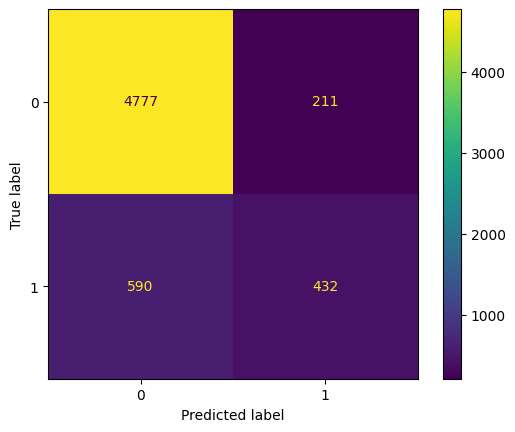

In [193]:
## Confusion Matrix

## Logistic Regression
cm_lr = confusion_matrix(y_train_s, y_train_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp.plot();

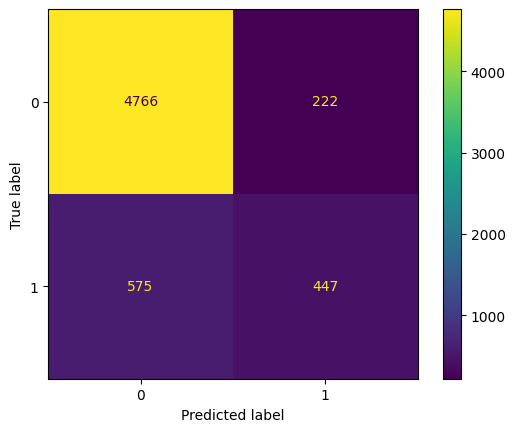

In [194]:
# Lasso
cm_lasso = confusion_matrix(y_train_s, y_train_pred_lasso)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lasso)
disp.plot();

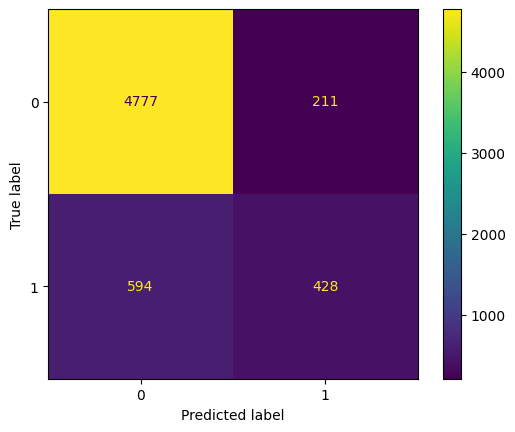

In [195]:
# LDA
cm_lda = confusion_matrix(y_train_s, y_train_pred_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lda)
disp.plot();

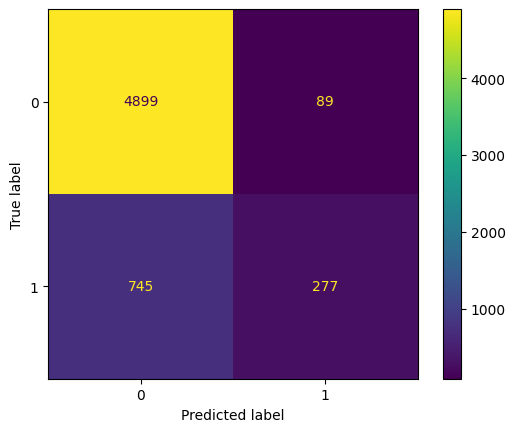

In [196]:
# Ridge classifier
cm_rr = confusion_matrix(y_train_s, y_train_pred_rr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rr)
disp.plot();

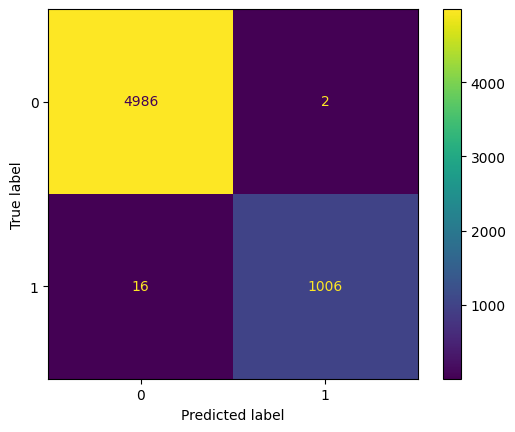

In [197]:
# Support Vector Machines
cm_svm = confusion_matrix(y_train_s, y_train_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp.plot();

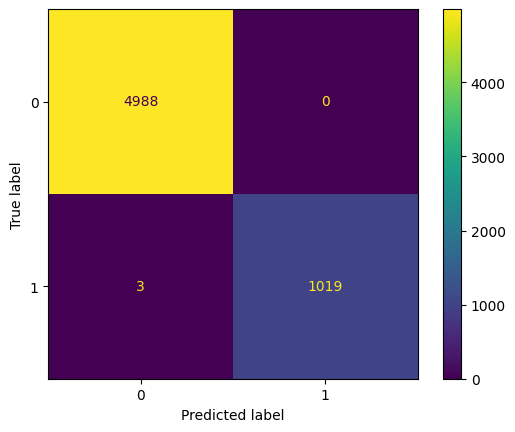

In [198]:
# Random Forest Classifier
cm_rf = confusion_matrix(y_train_s, y_train_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot();

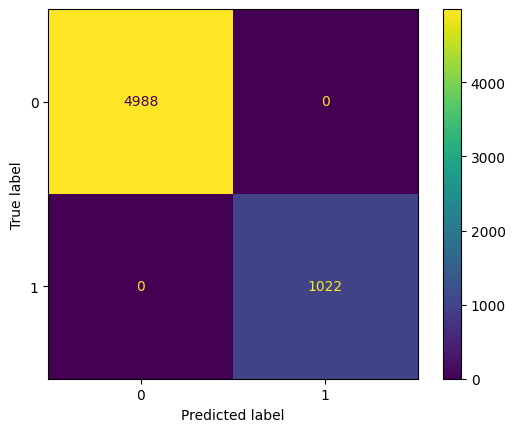

In [199]:
# XGB
cm_xgb = confusion_matrix(y_train_s, y_train_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot();

#### Cross validation

In [110]:
## Grid search CV with Random Forest
param_grid = {
    'randomforestclassifier__n_estimators': range(25, 100, 25),
    'randomforestclassifier__max_depth': range(10, 50, 10)
}


rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")

In [111]:
rf_cv.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['sex', 'region',
                                                            'area',
                                                            'child_ill_cough_two_weeks',
                                                            'child_ill_fever_two_weeks',
                                                            'child_had_diarrhoea_last_two_weeks',
                                                            'health_insurance',
                                                            'mother_educational_level',
                                                            'ethnicity'])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             scoring='accuracy', verbose=2)

In [123]:
cv_results = pd.DataFrame(rf_cv.cv_results_)
cv_results.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.330401,0.010632,0.032199,0.000399,40,25,"{'randomforestclassifier__max_depth': 40, 'ran...",0.867720,0.877704,0.893511,0.886023,0.866889,0.878369,0.010330,1
11,0.724006,0.022322,0.045605,0.002056,40,75,"{'randomforestclassifier__max_depth': 40, 'ran...",0.872712,0.873544,0.883527,0.892679,0.868552,0.878203,0.008751,2
8,0.771799,0.033106,0.051200,0.005634,30,75,"{'randomforestclassifier__max_depth': 30, 'ran...",0.869384,0.872712,0.884359,0.891847,0.868552,0.877371,0.009183,3
6,0.334200,0.015638,0.033799,0.003816,30,25,"{'randomforestclassifier__max_depth': 30, 'ran...",0.865225,0.873544,0.891015,0.886023,0.868552,0.876872,0.009997,4
5,0.785398,0.028010,0.049800,0.006179,20,75,"{'randomforestclassifier__max_depth': 20, 'ran...",0.868552,0.866889,0.885191,0.887687,0.873544,0.876373,0.008543,5
3,0.398909,0.047607,0.038001,0.005550,20,25,"{'randomforestclassifier__max_depth': 20, 'ran...",0.861897,0.874376,0.891847,0.884359,0.866057,0.875707,0.011144,6
7,0.534398,0.018216,0.039801,0.001719,30,50,"{'randomforestclassifier__max_depth': 30, 'ran...",0.869384,0.871048,0.881032,0.883527,0.873544,0.875707,0.005583,6
10,0.553796,0.017373,0.039200,0.001471,40,50,"{'randomforestclassifier__max_depth': 40, 'ran...",0.870216,0.871048,0.881032,0.883527,0.872712,0.875707,0.005483,6
4,0.530199,0.005195,0.041203,0.002785,20,50,"{'randomforestclassifier__max_depth': 20, 'ran...",0.865225,0.868552,0.881032,0.878536,0.864393,0.871547,0.006913,9
0,0.437397,0.071157,0.038001,0.005254,10,25,"{'randomforestclassifier__max_depth': 10, 'ran...",0.847754,0.846922,0.851913,0.858569,0.839434,0.848918,0.006283,10


In [127]:
rf_cv.best_params_ 

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 25}

In [131]:
## Grid search: XGBoost
param_grid_xgb = {
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__max_depth': [3, 6, 9],
    'xgbclassifier__subsample': [0.7, 0.8, 1]
}

xgb_cv = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb,
                     cv=5, n_jobs=-1, verbose=2, scoring="accuracy")

xgb_cv.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['sex', 'region',
                                                            'area',
                                                            'child_ill_cough_two_weeks',
                                                            'child_ill_fever_two_weeks',
                                                            'child_had_diarrhoea_last_two_weeks',
                                                            'health_insurance',
                                                            'mother_educational_level',
                                                            'ethnicity'],
                                                      use_cat_names=True)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgbclassifier__max_depth': [3, 6, 9],
                         'xgbclassifier__n_estimators': [100, 200, 300],
                         'xgbclassifier__subsample': [0.7, 0.8, 1]},
             scoring='accuracy', verbose=2)

In [134]:
xgb_cv.best_params_

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 9,
 'xgbclassifier__n_estimators': 200,
 'xgbclassifier__subsample': 0.7}

In [234]:
## Support Vector Machines
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto', 0.1, 1]
}

svm_cv = GridSearchCV(estimator=svm, param_grid=param_grid_svm,
                      cv=5, n_jobs=-1, verbose=2, scoring="accuracy")

svm_cv.fit(X_train_s, y_train_s)

svm_cv.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}

In [145]:
# Linear Discriminant Analysis

param_grid_lda = {
    'lineardiscriminantanalysis__solver': ['svd', 'lsqr', 'eigen'],
    'lineardiscriminantanalysis__shrinkage': [None, 'auto', 0.1, 0.5, 1]
}

lda_cv = GridSearchCV(estimator=lda, param_grid=param_grid_lda,
                      cv=5, n_jobs=-1, verbose=2, scoring="accuracy")

lda_cv.fit(X_train_s, y_train_s)

lda_cv.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\LENOVO\anaconda3\envs\ml_mics\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\LENOVO\anaconda3\envs\ml_mics\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\LENOVO\anaconda3\envs\ml_mics\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\LENOVO\anaconda3\envs\ml_mics\Lib\site-packages\sklearn\discriminant_analysis.py", line 631, in fit
 

{'lineardiscriminantanalysis__shrinkage': None,
 'lineardiscriminantanalysis__solver': 'svd'}

In [147]:
## Ridge regression
param_grid_ridge = {
    'ridgeclassifier__alpha': [0.1, 1, 10, 100],
    'ridgeclassifier__solver': ['auto', 'svd', 'cholesky']
}

rr_cv = GridSearchCV(estimator=rr, param_grid=param_grid_ridge,
                      cv=5, n_jobs=-1, verbose=2, scoring="accuracy")

rr_cv.fit(X_train_s, y_train_s)

rr_cv.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'ridgeclassifier__alpha': 1, 'ridgeclassifier__solver': 'auto'}

In [158]:
## LASSO
param_grid_lasso = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1'],
    'logisticregression__solver': ['liblinear', 'saga']  # solvers that support L1 penalty
}

lasso_cv = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso,
                     cv=5, n_jobs=-1, verbose=2, scoring="accuracy")

lasso_cv.fit(X_train_s, y_train_s)

lasso_cv.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'logisticregression__C': 10,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [178]:
rf_cv.best_score_

0.878369384359401

### Evaluate: Stunting models

In [169]:
# Evaluate models on test set
## Logistic Regression
y_test_pred_lr = lr.predict(X_test_s)
print(classification_report(y_test_s, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2114
           1       0.70      0.43      0.53       462

    accuracy                           0.86      2576
   macro avg       0.79      0.70      0.73      2576
weighted avg       0.85      0.86      0.85      2576



In [170]:
# LASSO
y_test_pred_lasso = lasso.predict(X_test_s)
print(classification_report(y_test_s, y_test_pred_lasso))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2114
           1       0.68      0.45      0.54       462

    accuracy                           0.86      2576
   macro avg       0.78      0.70      0.73      2576
weighted avg       0.85      0.86      0.85      2576



In [171]:
# LDA
y_test_pred_lda = lda.predict(X_test_s)
print(classification_report(y_test_s, y_test_pred_lasso))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2114
           1       0.68      0.45      0.54       462

    accuracy                           0.86      2576
   macro avg       0.78      0.70      0.73      2576
weighted avg       0.85      0.86      0.85      2576



In [172]:
# Ridge
y_test_pred_rr = lda.predict(X_test_s)
print(classification_report(y_test_s, y_test_pred_rr))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2114
           1       0.69      0.41      0.51       462

    accuracy                           0.86      2576
   macro avg       0.78      0.68      0.71      2576
weighted avg       0.85      0.86      0.85      2576



In [173]:
# SVM
y_test_pred_svm = svm.predict(X_test_s)
print(classification_report(y_test_s, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2114
           1       0.95      0.93      0.94       462

    accuracy                           0.98      2576
   macro avg       0.96      0.96      0.96      2576
weighted avg       0.98      0.98      0.98      2576



In [177]:
# Random forest
y_test_pred_rf = rf.predict(X_test_s)
print(classification_report(y_test_s, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2114
           1       0.90      0.39      0.54       462

    accuracy                           0.88      2576
   macro avg       0.89      0.69      0.74      2576
weighted avg       0.88      0.88      0.86      2576



In [175]:
# Extreme gradient
y_test_pred_xgb = xgb.predict(X_test_s)
print(classification_report(y_test_s, y_test_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2114
           1       0.97      0.90      0.93       462

    accuracy                           0.98      2576
   macro avg       0.97      0.94      0.96      2576
weighted avg       0.98      0.98      0.98      2576



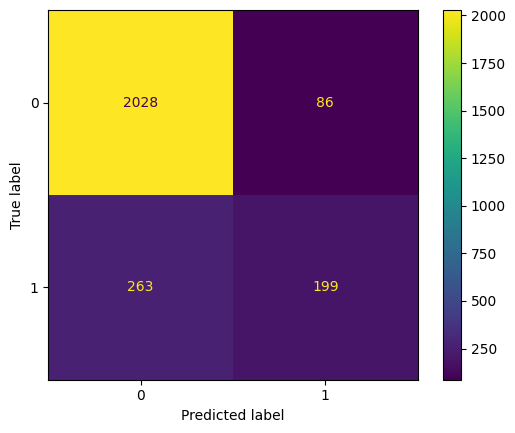

In [180]:
# Confusion Matrix

# Logistic Regression
cm_lr_test = confusion_matrix(y_test_s, y_test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_test)
disp.plot();

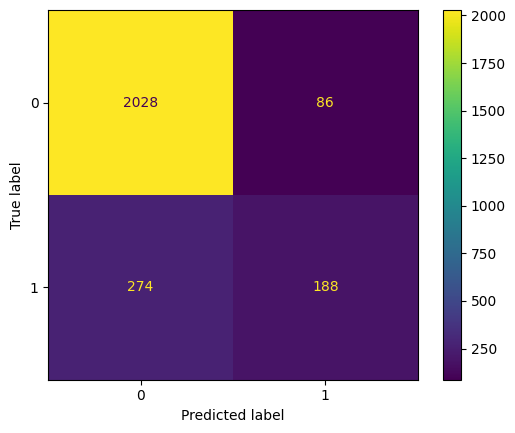

In [181]:
# Ridge
cm_rr_test = confusion_matrix(y_test_s, y_test_pred_rr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rr_test)
disp.plot();

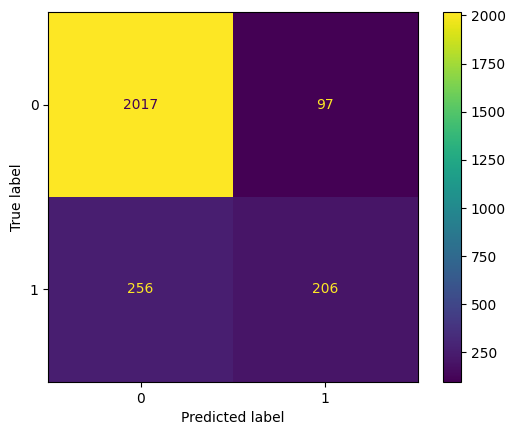

In [179]:
# Lasso
cm_lasso_test = confusion_matrix(y_test_s, y_test_pred_lasso)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lasso_test)
disp.plot();

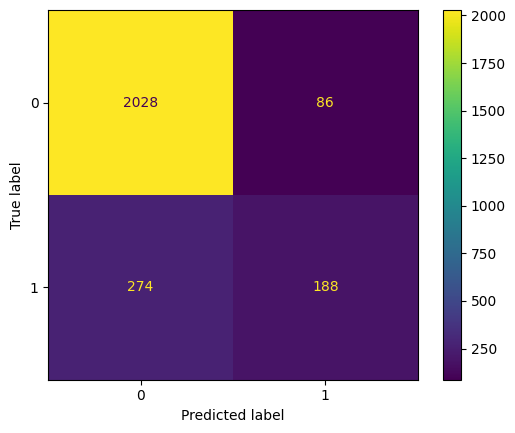

In [182]:
# LDA
cm_lda_test = confusion_matrix(y_test_s, y_test_pred_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lda_test)
disp.plot();

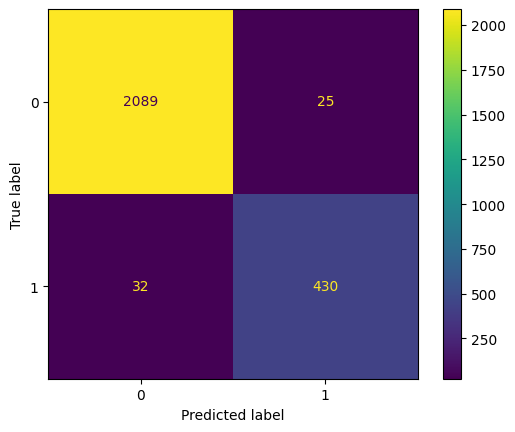

In [183]:
# SVM
cm_svm_test = confusion_matrix(y_test_s, y_test_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_test)
disp.plot();

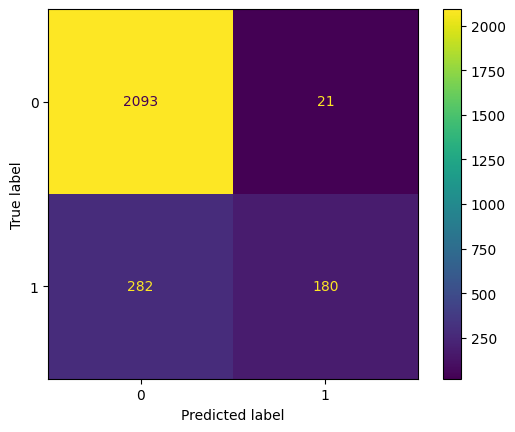

In [184]:
# RF
cm_rf_test = confusion_matrix(y_test_s, y_test_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_test)
disp.plot();

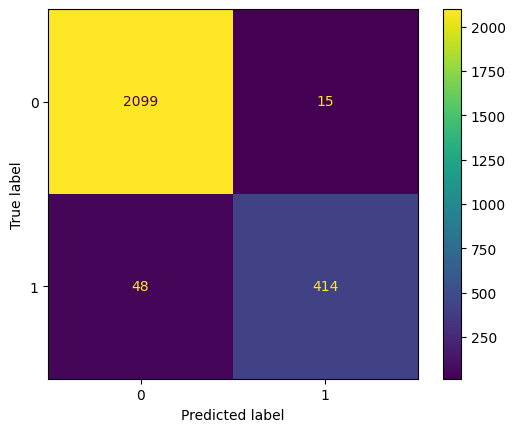

In [185]:
# XGboost
cm_xgb_test = confusion_matrix(y_test_s, y_test_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_test)
disp.plot();

In [200]:
# Compute ROC Curve and AUC
# Initialize lists to hold false positive rates, true positive rates, and areas under the curve
fprs, tprs, aucs = [], [], []

models = [lr, lasso, lda,svm, rf, xgb]
model_names = ["Logistic Regression", 
               "Least Absolute Shrinkage and Selection Operation", 
               "Linear Discriminant Analysis",
               "Support Vector Machine",
               "Random Forest", 
               "Extreme Gradient Boosting"]

for model, name in zip(models, model_names):
    y_scores = model.predict_proba(X_test_s)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_s, y_scores)
    roc_auc = auc(fpr, tpr)

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

    print(f"{name} AUC: {roc_auc:.2f}")


Logistic Regression AUC: 0.90
Least Absolute Shrinkage and Selection Operation AUC: 0.90
Linear Discriminant Analysis AUC: 0.89
Support Vector Machine AUC: 1.00
Random Forest AUC: 0.92
Extreme Gradient Boosting AUC: 1.00


In [201]:
# For RidgeClassifier using decision_function
y_scores_ridge = rr.decision_function(X_test_s)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test_s, y_scores_ridge)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)

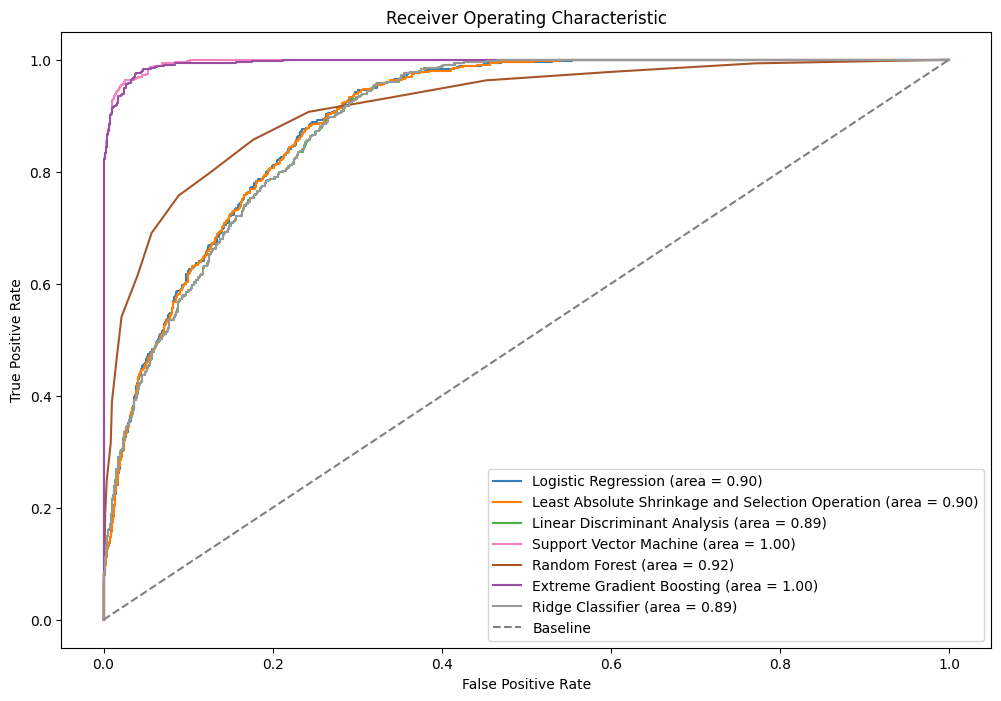

In [203]:
plt.figure(figsize=(12, 8))

# Existing model curves
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf',
          '#a65628', '#984ea3']
for fpr, tpr, roc_auc, color, name in zip(fprs, tprs, aucs, colors, model_names):
    plt.plot(fpr, tpr, color=color, label=f'{name} (area = {roc_auc:.2f})')

# Add RidgeClassifier's ROC curve
plt.plot(fpr_ridge, tpr_ridge, color='#999999',
         label=f'Ridge Classifier (area = {roc_auc_ridge:.2f})')

# Plot Base Rate ROC
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline')

# Additional plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [213]:
# Get feature importance
booster = xgb.named_steps["xgbclassifier"].get_booster()
# Importance types["weight", "gain", "cover"]
importance = booster.get_score(importance_type='gain')

# Transforming the importance dictionary into lists for plotting
f_names = list(importance.keys())
f_importance = list(importance.values())

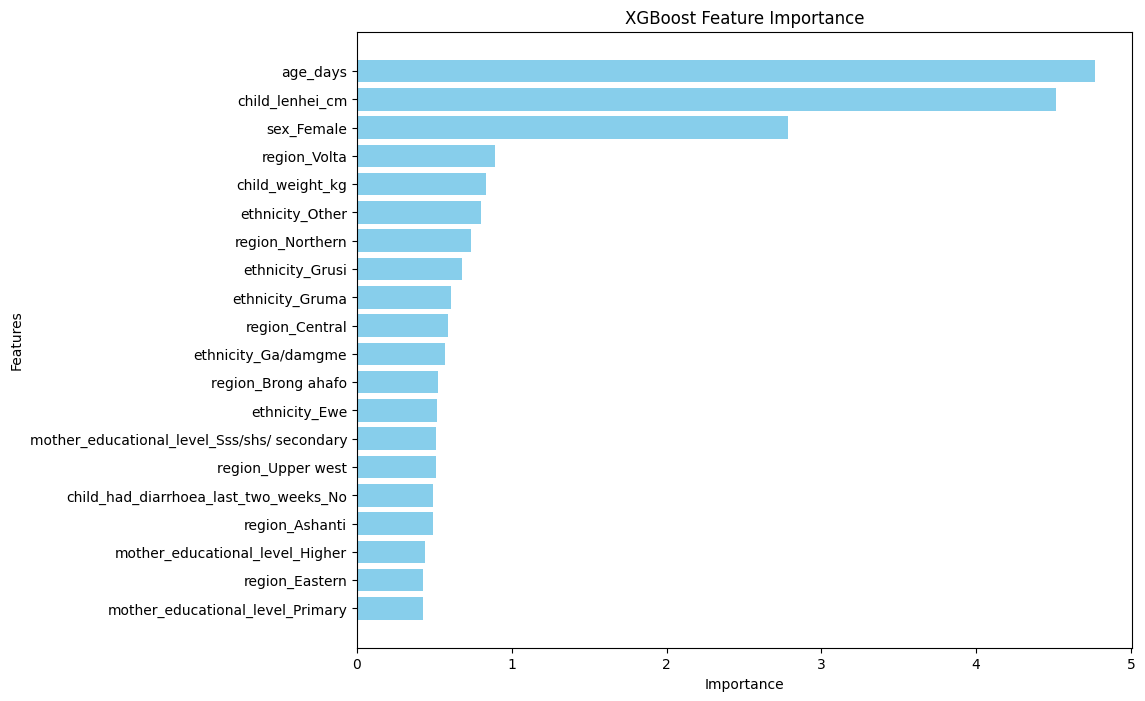

In [214]:
# Sorting the feature importances
sorted_indices = sorted(range(len(f_importance)),
                        key=lambda k: f_importance[k], reverse=True)
# Top 20 features
top_n = 20
sorted_importance = [f_importance[idx] for idx in sorted_indices[:top_n]]
sorted_names = [f_names[idx] for idx in sorted_indices[:top_n]]


# Create plot
plt.figure(figsize=(10, 8))

# Create horizontal bars
plt.barh(range(len(sorted_importance)), sorted_importance, color='skyblue')

# Create names on the y-axis
plt.yticks(range(len(sorted_importance)), sorted_names)

# Invert y-axis to have the highest importance at the top
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')

# Show plot
plt.show()

### Modelling: Underweight

In [235]:
# Find best models to use to fit underweight data
lasso_cv_u = lasso_cv
lasso_cv_u.fit(X_train_u, y_train_u) # Lasso

rr_cv_u = rr_cv
rr_cv_u.fit(X_train_u, y_train_u) # Ridge

lda_cv_u = lda_cv
lda_cv_u.fit(X_train_u, y_train_u) # LDA

svm_cv_u = svm_cv
svm_cv_u.fit(X_train_u, y_train_u) # SVM

rf_cv_u = rf_cv
rf_cv_u.fit(X_train_u, y_train_u) # RF

xgb_cv_u = xgb_cv
xgb_cv_u.fit(X_train_u, y_train_u) # XGB

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\LENOVO\anaconda3\envs\ml_mics\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\LENOVO\anaconda3\envs\ml_mics\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\LENOVO\anaconda3\envs\ml_mics\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\LENOVO\anaconda3\envs\ml_mics\Lib\site-packages\sklearn\discriminant_analysis.py", line 631, in fit
 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['sex', 'region',
                                                            'area',
                                                            'child_ill_cough_two_weeks',
                                                            'child_ill_fever_two_weeks',
                                                            'child_had_diarrhoea_last_two_weeks',
                                                            'health_insurance',
                                                            'mother_educational_level',
                                                            'ethnicity'],
                                                      use_cat_names=True)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgbclassifier__max_depth': [3, 6, 9],
                         'xgbclassifier__n_estimators': [100, 200, 300],
                         'xgbclassifier__subsample': [0.7, 0.8, 1]},
             scoring='accuracy', verbose=2)

Logistic Regression:               precision    recall  f1-score   support

           0       0.95      0.98      0.96      5295
           1       0.77      0.59      0.67       715

    accuracy                           0.93      6010
   macro avg       0.86      0.78      0.81      6010
weighted avg       0.93      0.93      0.93      6010

Least Absolute Shrinkage and Selection Operation:               precision    recall  f1-score   support

           0       0.95      0.97      0.96      5295
           1       0.77      0.64      0.70       715

    accuracy                           0.93      6010
   macro avg       0.86      0.81      0.83      6010
weighted avg       0.93      0.93      0.93      6010

Linear Discriminant Analysis:               precision    recall  f1-score   support

           0       0.92      0.99      0.95      5295
           1       0.83      0.34      0.48       715

    accuracy                           0.91      6010
   macro avg       0.87    

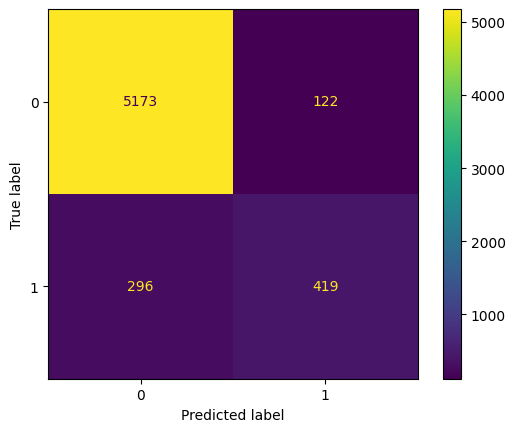

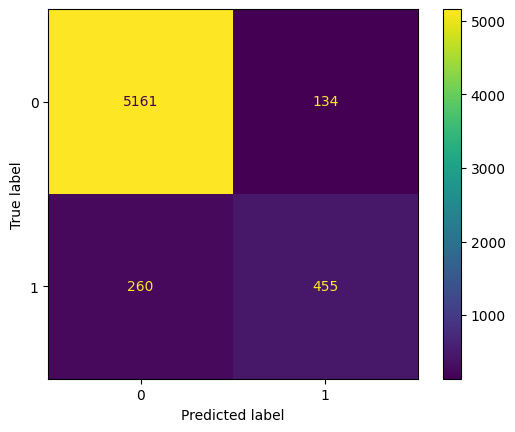

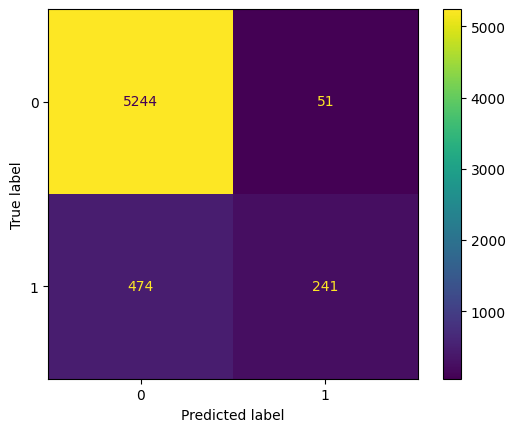

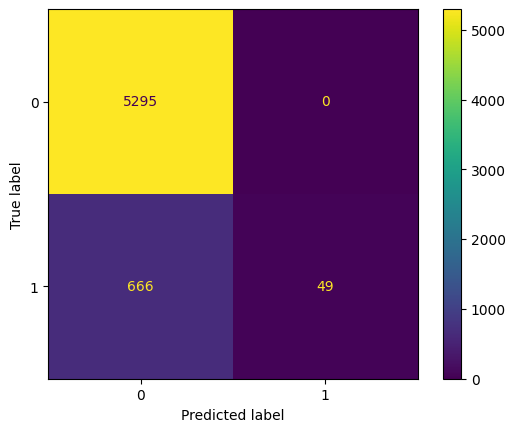

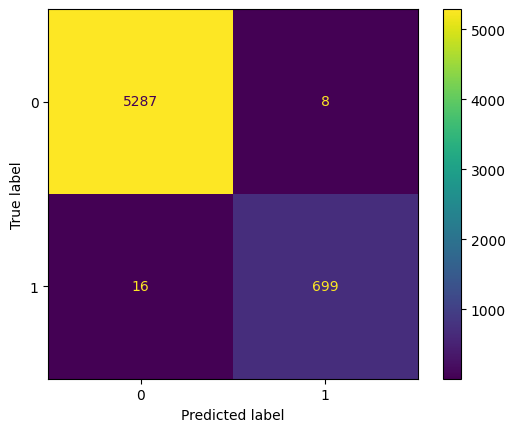

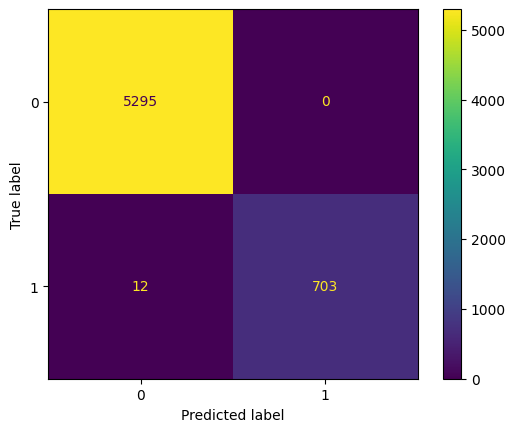

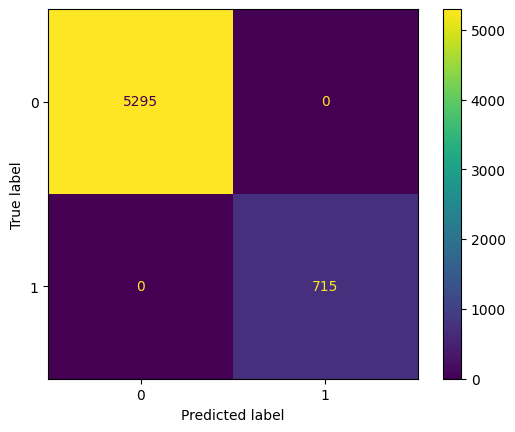

In [230]:
models_list = [lr, lasso_cv_u, lda_cv_u, rr_cv_u, svm_cv_u, rf_cv_u, xgb_cv_u]
model_names_list = ["Logistic Regression",
               "Least Absolute Shrinkage and Selection Operation",
               "Linear Discriminant Analysis",
               "Ridge Classifier",
               "Support Vector Machine",
               "Random Forest",
               "Extreme Gradient Boosting"]

for model,name in zip(models_list,model_names_list):
    y_train_pred = model.predict(X_train_u)
    print(f"{name}: {classification_report(y_train_u, y_train_pred)}")
    cm = confusion_matrix(y_train_u, y_train_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

In [233]:
# Compute ROC Curve and AUC
models_u = [lr, lasso_cv_u, lda_cv_u, svm_cv_u, rf_cv_u, xgb_cv_u]
model_names_u = ["Logistic Regression",
                    "Least Absolute Shrinkage and Selection Operation",
                    "Linear Discriminant Analysis",
                    "Support Vector Machine"
                    "Random Forest",
                    "Extreme Gradient Boosting"]
# Initialize lists to hold false positive rates, true positive rates, and areas under the curve
fprs_u, tprs_u, aucs_u = [], [], []

for model, name in zip(models_u, model_names_u):
    y_scores = model.predict_proba(X_test_u)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_u, y_scores)
    roc_auc = auc(fpr, tpr)

    fprs_u.append(fpr)
    tprs_u.append(tpr)
    aucs_u.append(roc_auc)

    print(f"{name} AUC: {roc_auc:.2f}")

Logistic Regression AUC: 0.96
Least Absolute Shrinkage and Selection Operation AUC: 0.96
Linear Discriminant Analysis AUC: 0.95
Random Forest AUC: 0.94
Extreme Gradient Boosting AUC: 1.00


In [ ]:
# For RidgeClassifier using decision_function
y_scores_rr_u = rr.decision_function(X_test_u)
fpr_rr_u, tpr_rr_u, _ = roc_curve(y_test_u, y_scores_rr_u)
roc_auc_ridge = auc(fpr_rr_u, tpr_rr_u)